# 💓 Heart Disease Prediction Project

## 📌 Goal

Build a machine learning pipeline that can predict whether a person is likely to have heart disease based on clinical features. This tool aims to assist in early detection and encourage timely medical follow-up.

# 🧠 Problem Motivation

Heart disease is one of the leading causes of death worldwide. Early detection is critical for treatment and prevention. By leveraging clinical data and machine learning, we aim to build a predictive model that can:

- Provide a second opinion to healthcare providers.

- Raise awareness for patients at risk.

- Be deployed as a simple, interactive web app.

# 📁 Dataset and Features

We use a structured dataset where each row represents a patient, and columns represent clinical measurements.

## Selected Features for Re-Training:

- oldpeak

- sex

- exercise angina

- fasting blood sugar

- chest pain type

- cholesterol

- max heart rate

- resting bp s

- age

- resting ecg

- ST slope

## Target:

target: 1 = Heart Disease, 0 = No Disease

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import json
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('dataset.csv')

In [3]:
# Display the first few rows
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [4]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [5]:
print(df.describe())

               age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190.000000      1190.000000   1190.000000  1190.000000   
mean     53.720168     0.763866         3.232773    132.153782   210.363866   
std       9.358203     0.424884         0.935480     18.368823   101.420489   
min      28.000000     0.000000         1.000000      0.000000     0.000000   
25%      47.000000     1.000000         3.000000    120.000000   188.000000   
50%      54.000000     1.000000         4.000000    130.000000   229.000000   
75%      60.000000     1.000000         4.000000    140.000000   269.750000   
max      77.000000     1.000000         4.000000    200.000000   603.000000   

       fasting blood sugar  resting ecg  max heart rate  exercise angina  \
count          1190.000000  1190.000000     1190.000000      1190.000000   
mean              0.213445     0.698319      139.732773         0.387395   
std               0.409912     0.870359       25.517636     

In [6]:
# Check for missing values
df.isnull().sum()


age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

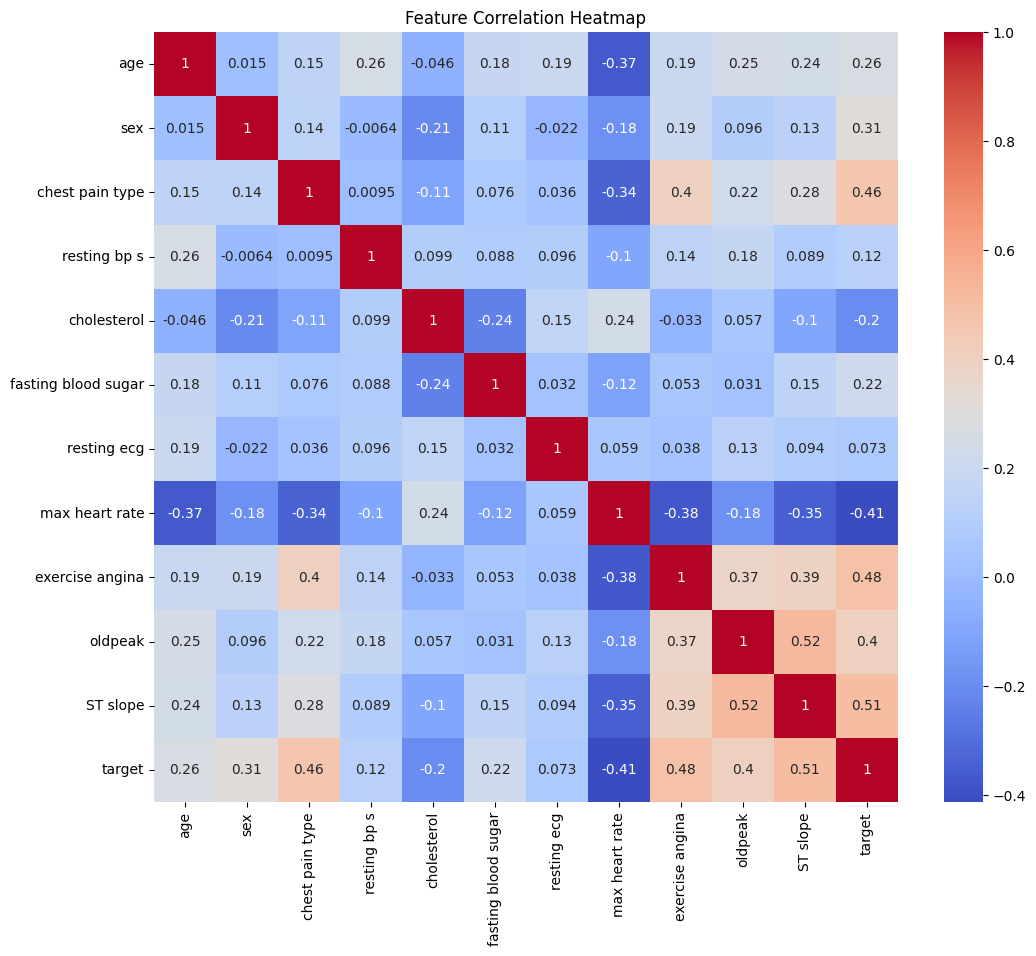

In [7]:
# Visualize correlation
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Define features and target
X = df.drop(columns=['target'])
y = df['target']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


joblib.dump(list(X.columns), "feature_names.pkl")
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [9]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.949580,0.947368,0.961832,0.954545,0.968824
1,Gradient Boosting,0.915966,0.917293,0.931298,0.924242,0.959834
2,Decision Tree,0.890756,0.926829,0.870229,0.897638,0.893058
3,AdaBoost,0.878151,0.875000,0.908397,0.891386,0.936470
4,Logistic Regression,0.861345,0.871212,0.877863,0.874525,0.908540
5,K-Nearest Neighbors,0.718487,0.753968,0.725191,0.739300,0.778483
6,Support Vector Machine,0.726891,0.779661,0.702290,0.738956,0.781979


# Hyperparameter Tuning the top three models

In [10]:
def run_grid_search(model, param_grid, model_name):
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_scaled, y_train)
    print(f"Best F1 score for {model_name}: {grid.best_score_:.4f}")
    print(f"Best Parameters for {model_name}: {grid.best_params_}")
    return grid.best_estimator_

# Random Forest
param_grid_rf = {
    'n_estimators': [50, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
best_rf = run_grid_search(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")

# Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}
best_gb = run_grid_search(GradientBoostingClassifier(random_state=42), param_grid_gb, "Gradient Boosting")

# Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
best_dt = run_grid_search(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree")


Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best F1 score for Random Forest: 0.9100
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuning Gradient Boosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best F1 score for Gradient Boosting: 0.9021
Best Parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Tuning Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best F1 score for Decision Tree: 0.8694
Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


# Various ensemble methods

In [11]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bag = bagging_model.predict(X_test_scaled)
y_proba_bag = bagging_model.predict_proba(X_test)[:, 1]

print("Bagging Classifier Report:\n", classification_report(y_test, y_pred_bag))
print("Bagging Classifier Accuracy:", accuracy_score(y_test, y_pred_bag))
print("Bagging Classifier F1 Score:", f1_score(y_test, y_pred_bag))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bag))
print("ROC AUC:", roc_auc_score(y_test, y_proba_bag))


Bagging Classifier Report:
               precision    recall  f1-score   support

           0       0.57      0.77      0.65       107
           1       0.73      0.53      0.61       131

    accuracy                           0.63       238
   macro avg       0.65      0.65      0.63       238
weighted avg       0.66      0.63      0.63       238

Bagging Classifier Accuracy: 0.634453781512605
Bagging Classifier F1 Score: 0.6133333333333333
Confusion Matrix:
 [[82 25]
 [62 69]]
ROC AUC: 0.9645430548619534


In [12]:
voting = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),  
        ('svc', best_dt)     
    ],
    voting='soft'
)

voting.fit(X_train, y_train)

y_pred_vote = voting.predict(X_test_scaled)
y_proba_vote = voting.predict_proba(X_test)[:, 1]

print("Voting Classifier Report:\n", classification_report(y_test, y_pred_vote))
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Voting Classifier F1 Score:", f1_score(y_test, y_pred_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_vote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_vote))

Voting Classifier Report:
               precision    recall  f1-score   support

           0       0.50      0.62      0.55       107
           1       0.61      0.49      0.54       131

    accuracy                           0.55       238
   macro avg       0.55      0.55      0.55       238
weighted avg       0.56      0.55      0.55       238

Voting Classifier Accuracy: 0.5462184873949579
Voting Classifier F1 Score: 0.5423728813559322
Confusion Matrix:
 [[66 41]
 [67 64]]
ROC AUC: 0.9699650424484554


In [13]:
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('svc', best_dt)
]

# Meta-model: Logistic Regression
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10),
    cv=5,
    passthrough=True,  # Optional: allows meta-model to access original features too
    n_jobs=-1
)

# Train
stacking_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking_model.predict(X_test_scaled)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

print("Stacking Classifier Report:\n", classification_report(y_test, y_pred_stack))
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Classifier F1 Score:", f1_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("ROC AUC:", roc_auc_score(y_test, y_proba_stack))

Stacking Classifier Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69       107
           1       0.75      0.74      0.74       131

    accuracy                           0.72       238
   macro avg       0.72      0.72      0.72       238
weighted avg       0.72      0.72      0.72       238

Stacking Classifier Accuracy: 0.7184873949579832
Stacking Classifier F1 Score: 0.7432950191570882
Confusion Matrix:
 [[74 33]
 [34 97]]
ROC AUC: 0.7526574873368054


                 Model  Accuracy  F1 Score
0        Random Forest  0.949580  0.954545
2    Gradient Boosting  0.928571  0.935849
1        Decision Tree  0.903361  0.909804
3  Stacking Classifier  0.718487  0.743295
5   Bagging Classifier  0.634454  0.613333
4    Voting Classifier  0.546218  0.542373


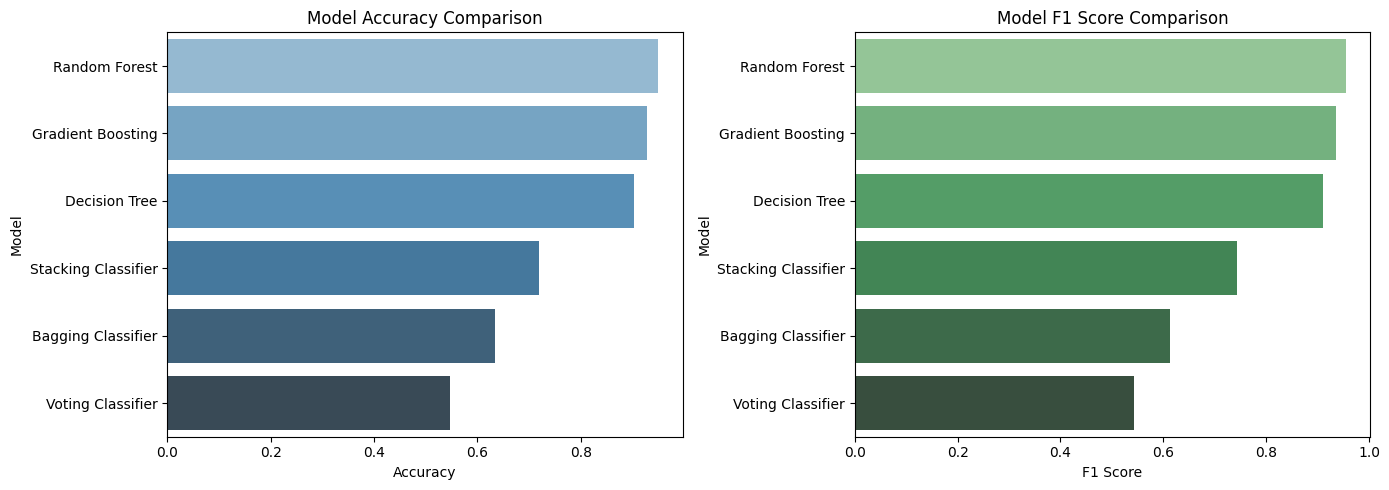

In [14]:
# Dictionary of all models you trained
models = {
    "Random Forest": best_rf,
    "Decision Tree": best_dt,
    "Gradient Boosting": best_gb,
    "Stacking Classifier": stacking_model,
    "Voting Classifier": voting,
    "Bagging Classifier": bagging_model
}

# Dictionary to store metrics
results = {
    "Model": [],
    "Accuracy": [],
    "F1 Score": []
}

# Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["F1 Score"].append(f1_score(y_test, y_pred))

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)

# Plot Accuracy and F1 Score
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x="Accuracy", y="Model", data=results_df, ax=ax[0], palette="Blues_d")
ax[0].set_title("Model Accuracy Comparison")

sns.barplot(x="F1 Score", y="Model", data=results_df, ax=ax[1], palette="Greens_d")
ax[1].set_title("Model F1 Score Comparison")

plt.tight_layout()
plt.show()



<b><u> Since According to our model accuracy and F1 score the individual RandomForest Classifier has more power, we will train it and use it as our best model.</b></u>

In [15]:


# Predict
y_pred_rf = best_rf.predict(X_test_scaled)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print("Random Forest Report:\n", report_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest F1 Score:", f1_rf)
# Save metrics as JSON
rf_metrics = {
    "accuracy": accuracy_rf,
    "f1_score": f1_rf,
    "classification_report": report_rf
}

with open("rf_metrics.json", "w") as f:
    json.dump(rf_metrics, f, indent=4)

print("✅ RF metrics saved to rf_metrics.json")

# Save model
joblib.dump(best_rf, "best_model.pkl")
print("✅ Trained RF model saved as best_model.pkl")

Random Forest Report:
 {'0': {'precision': 0.9523809523809523, 'recall': 0.9345794392523364, 'f1-score': 0.9433962264150944, 'support': 107.0}, '1': {'precision': 0.9473684210526315, 'recall': 0.9618320610687023, 'f1-score': 0.9545454545454546, 'support': 131.0}, 'accuracy': 0.9495798319327731, 'macro avg': {'precision': 0.949874686716792, 'recall': 0.9482057501605194, 'f1-score': 0.9489708404802745, 'support': 238.0}, 'weighted avg': {'precision': 0.9496219540447757, 'recall': 0.9495798319327731, 'f1-score': 0.949532986436427, 'support': 238.0}}
Random Forest Accuracy: 0.9495798319327731
Random Forest F1 Score: 0.9545454545454546
✅ RF metrics saved to rf_metrics.json
✅ Trained RF model saved as best_model.pkl


# Visualizing the best Features

✅ Permutation importance saved


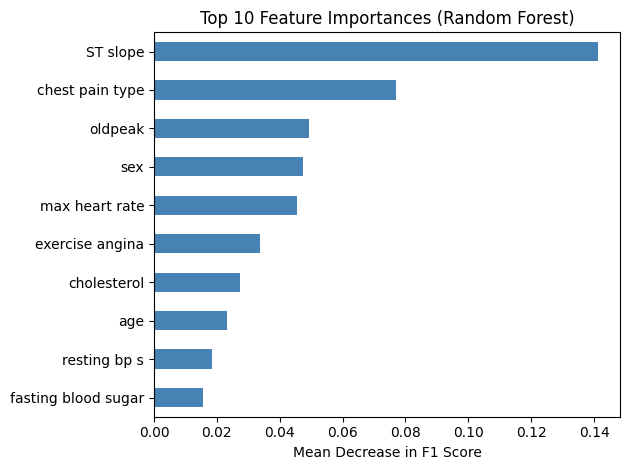

Top 10 Permutation Features:
1. ST slope
2. chest pain type
3. oldpeak
4. sex
5. max heart rate
6. exercise angina
7. cholesterol
8. age
9. resting bp s
10. fasting blood sugar


In [16]:
# Permutation Importance
perm = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_series = pd.Series(perm.importances_mean, index=X.columns)

# Save permutation importance
joblib.dump(perm_series, "permutation_importance.pkl")
print("✅ Permutation importance saved")

# Plot top 10 features
top_10_rf = perm_series.sort_values(ascending=False).head(10)
top_10_rf[::-1].plot(kind='barh', color='steelblue')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Permutation Features:")
for i, feat in enumerate(top_10_rf.index, 1):
    print(f"{i}. {feat}")